In [2]:
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx = np.exp(2j * np.pi * f_tone * t)


In [3]:
d = 0.5 # half wavelength spacing
Nr = 3
theta_degrees = 20 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Steering Vector
print(a) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j          0.47618256-0.87934645j -0.54650034-0.83745888j]


In [4]:
a = a.reshape(-1,1)
print(a.shape) # 3x1
tx = tx.reshape(-1,1)
print(tx.shape) # 10000x1

# matrix multiply
r = a @ tx.T  # dont get too caught up by the transpose, the important thing is we're multiplying the Steering Vector by the tx signal
print(r.shape) # 3x10000.  r is now going to be a 2D array, 1D is time and 1D is the spatial dimension
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
r = r + 0.5*n # r and n are both 3x10000


(3, 1)
(10000, 1)
(3, 10000)


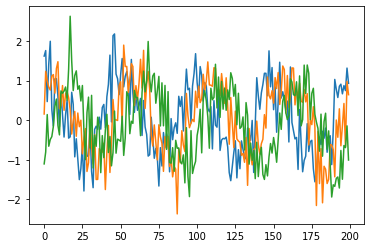

In [5]:
plt.plot(np.asarray(r[0,:]).squeeze().real[0:200]) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(r[1,:]).squeeze().real[0:200])
plt.plot(np.asarray(r[2,:]).squeeze().real[0:200])
plt.show()

In [68]:
num_expected_signals = 1

In [69]:
R = r @ r.conj().T
R

array([[15040.94678338   +0.j        ,  4784.42088302+8871.77515655j,
        -5522.41148042+8272.69622683j],
       [ 4784.42088302-8871.77515655j, 15129.37658131   +0.j        ,
         4745.74623951+8885.16081262j],
       [-5522.41148042-8272.69622683j,  4745.74623951-8885.16081262j,
        15029.41800225   +0.j        ]])

In [70]:
w, v = np.linalg.eig(R) # eigenvalue decomposition, v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
w.shape, v.shape

((3,), (3, 3))

In [71]:
v

array([[ 0.27295062+0.5073244j ,  0.28046024-0.64164123j,
        -0.28668677-0.30914267j],
       [ 0.58020586+0.j        ,  0.10088329-0.06887859j,
         0.80525739+0.j        ],
       [ 0.2707505 -0.50810948j,  0.70336113+0.j        ,
        -0.2831994 +0.3059414j ]])

In [72]:
eig_val_order = np.argsort(np.abs(w)) # find order of magnitude of eigenvalues
eig_val_order

array([2, 1, 0])

In [73]:
v = v[:, eig_val_order] # sort eigenvectors using this order
v

array([[-0.28668677-0.30914267j,  0.28046024-0.64164123j,
         0.27295062+0.5073244j ],
       [ 0.80525739+0.j        ,  0.10088329-0.06887859j,
         0.58020586+0.j        ],
       [-0.2831994 +0.3059414j ,  0.70336113+0.j        ,
         0.2707505 -0.50810948j]])

In [74]:
# We make a new eigenvector matrix representing the "noise subspace", it's just the rest of the eigenvalues
V = np.zeros((Nr, Nr - num_expected_signals), dtype=np.complex64)
V

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]], dtype=complex64)

In [75]:
for i in range(Nr - num_expected_signals):
   V[:, i] = v[:, i]
V

array([[-0.28668678-0.30914268j,  0.28046024-0.64164126j],
       [ 0.8052574 +0.j        ,  0.10088329-0.06887859j],
       [-0.2831994 +0.3059414j ,  0.70336115+0.j        ]],
      dtype=complex64)

In [76]:
theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # -180 to +180 degrees
theta_scan.shape

(1000,)

In [77]:
results = []
arrival_angle = theta_scan[0]
max_power = -9999
for theta_i in theta_scan:
    a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Steering Vector
    a = a.reshape(-1,1)
    metric = 1 / (a.conj().T @ V @ V.conj().T @ a) # The main MUSIC equation
    metric = np.abs(metric.squeeze()) # take magnitude
    metric = 10*np.log10(metric) # convert to dB
    if metric > max_power:
        max_power = metric
        arrival_angle = theta_i
        print(metric, arrival_angle)
    results.append(metric)



-2.3975795120778596 -3.141592653589793
-2.340722519759725 0.0031447373909805343
-2.2241443277936344 0.009434212172942047
-2.103655806998247 0.01572368695490356
-1.9791421989792888 0.022013161736865072
-1.850482494758923 0.028302636518826585
-1.7175489179865553 0.0345921113007881
-1.580206356930245 0.040881586082750054
-1.4383117389243674 0.04717106086471157
-1.2917133400216358 0.05346053564667308
-1.1402500215122449 0.05975001042863459
-0.9837503836968432 0.0660394852105961
-0.8220318257967152 0.07232895999255762
-0.6548994991059486 0.07861843477451913
-0.4821451383791292 0.08490790955648064
-0.3035457539323065 0.09119738433844216
-0.11886216392534105 0.09748685912040367
0.07216265732166302 0.10377633390236518
0.2698054434868256 0.1100658086843267
0.4743647466749776 0.1163552834662882
0.6861633343481643 0.12264475824825016
0.905550920867332 0.12893423303021168
1.132907291445582 0.1352237078121732
1.368645888300998 0.1415131825941347
1.613217943714198 0.1478026573760962
1.86711726337105

In [66]:
results /= np.max(results) # normalize

In [67]:
np.max(results)

1.000000000000033

In [54]:
arrival_angle * 180 / np.pi

9.909909909909892

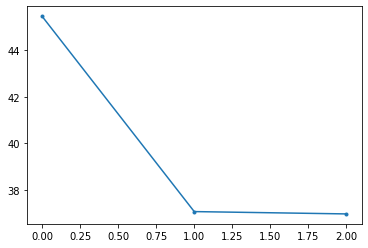

In [43]:
plt.plot(10*np.log10(np.abs(w)),'.-')